# AIS Examples

This example uses AIS data to show how to read and write information using PyMEOS.
It is divided in 3 sections, each corresponding to one MEOS example:
- [Reading from File](https://libmeos.org/tutorialprograms/meos_read_ais/)
- [Assembling Trips](https://libmeos.org/tutorialprograms/meos_assemble_ais/)
- [Storing in MobilityDB](https://libmeos.org/tutorialprograms/meos_store_ais/)

This example uses the plotting and database capabilities of PyMEOS. To get the necessary dependencies, you can install pymeos specifying this options:
```shell
pip install pymeos[db,plot]
```

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from pymeos import *

pymeos_initialize()

## Reading from File ([MEOS Example](https://libmeos.org/tutorialprograms/meos_read_ais/))
In this section, AIS data is read from a CSV file. We then use the read information to recreate the trajectories of the ships.



First, let's read the CSV file using pandas.

In [2]:
ais = pd.read_csv('./data/aisinput.csv')
ais.head()

,t,mmsi,latitude,longitude,sog
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0.0
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0.0
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0.0
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0.0
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0.0


Now, we will create the PyMEOS object representing the position and the SOG.

In [3]:
ais['point'] = ais.apply(lambda row: TGeogPointInst(point=(row['longitude'], row['latitude']), timestamp=row['t']),
                         axis=1)
ais['sog'] = ais.apply(lambda row: TFloatInst(value=row['sog'], timestamp=row['t']), axis=1)
ais['geometry'] = ais.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
ais.drop(['latitude', 'longitude'], axis=1, inplace=True)
ais.head()

,t,mmsi,sog,point,geometry
0,2021-01-08 00:00:00,265513270,0@2021-01-08 00:00:00+01,0101000020E61000004CA59F70768B2840643BDF4F8D87...,POINT (12.272388 57.059)
1,2021-01-08 00:00:01,219027804,0@2021-01-08 00:00:01+01,0101000020E6100000137D3ECA88BB27409B38B9DFA1F8...,POINT (11.866278 55.94244)
2,2021-01-08 00:00:01,265513270,0@2021-01-08 00:00:01+01,0101000020E61000004CA59F70768B2840643BDF4F8D87...,POINT (12.272388 57.059)
3,2021-01-08 00:00:03,219027804,0@2021-01-08 00:00:03+01,0101000020E6100000137D3ECA88BB27409B38B9DFA1F8...,POINT (11.866278 55.94244)
4,2021-01-08 00:00:04,265513270,0@2021-01-08 00:00:04+01,0101000020E61000004CA59F70768B2840643BDF4F8D87...,POINT (12.272388 57.059)


## Assembling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_assemble_ais/))

Now, we will create the trajectory (TGeogPointSeq) and the SOG evolution (TFloatSeq) for every ship (identified by the mmsi) using the instants we have created.

In [4]:
trajectories = ais.groupby('mmsi').aggregate(
    {
        'point': TGeogPointSeq.from_instants,
        'sog': TFloatSeq.from_instants
    }
).rename({'point': 'trajectory'}, axis=1)
trajectories['distance'] = trajectories['trajectory'].apply(lambda t: t.length())
trajectories.head()

,trajectory,sog,distance
mmsi,,,
219001559,[0101000020E61000000BB6114F76F32340191C25AFCEC...,"[0@2021-01-08 00:00:05+01, 0@2021-01-08 23:59:...",5202.381847
219027804,[0101000020E6100000137D3ECA88BB27409B38B9DFA1F...,"[0@2021-01-08 00:00:01+01, 0@2021-01-08 10:04:...",64865.704162
257136000,[0101000020E61000005320B3B3E87D1C4023A0C211A47...,"[14@2021-01-08 00:02:57+01, 13@2021-01-08 00:0...",647535.585121
265513270,[0101000020E61000004CA59F70768B2840643BDF4F8D8...,"[0@2021-01-08 00:00:00+01, 0@2021-01-08 23:59:...",11.695976
566948000,[0101000020E61000005E83BEF4F67712403332C85D84C...,"[0@2021-01-08 00:00:04+01, 0@2021-01-08 16:40:...",14932.332003


Here we can see that PyMEOS has been able to greatly reduce the number of points stored (and thus memory used) without losing any information.

In [5]:
pd.concat([ais.groupby('mmsi')['t'].count().rename('original #points'),
           trajectories['trajectory'].apply(lambda t: t.num_instants).rename('PyMEOS #points')],
          axis=1)

,original #points,PyMEOS #points
mmsi,,
219001559,48323,<bound method Temporal.num_instants of TGeogPo...
219027804,38326,<bound method Temporal.num_instants of TGeogPo...
257136000,21770,<bound method Temporal.num_instants of TGeogPo...
265513270,21799,<bound method Temporal.num_instants of TGeogPo...
566948000,26619,<bound method Temporal.num_instants of TGeogPo...


We can visualize the trajectories and the SOG evolutions by plotting them.

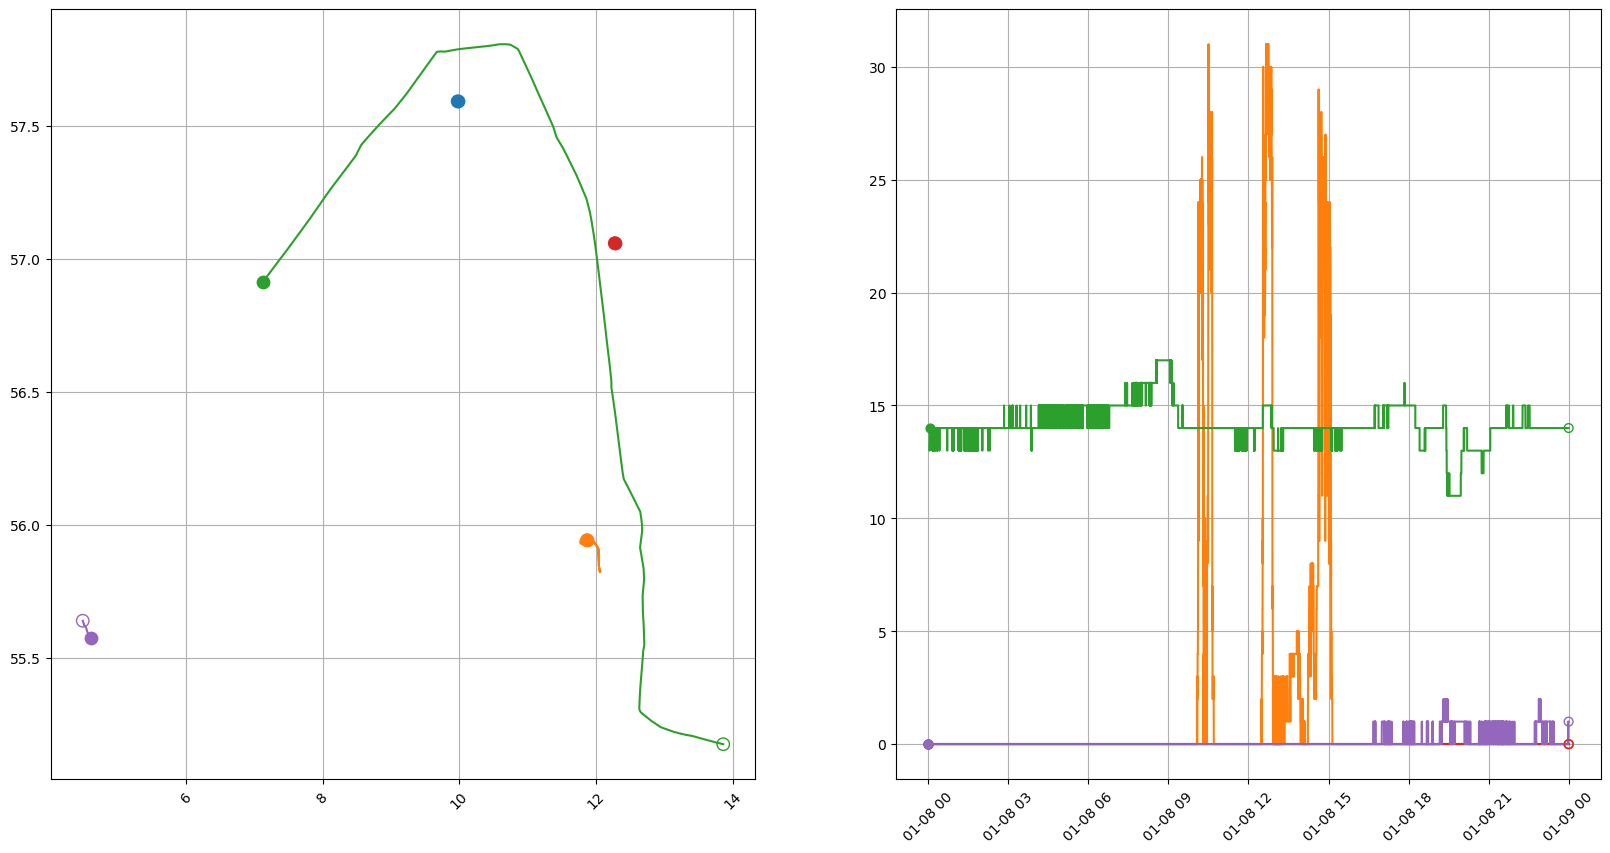

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for _, ship in trajectories.iterrows():
    ship['trajectory'].plot(axes=axes[0])
    ship['sog'].plot(axes=axes[1])
plt.show()

## Calculating temporal distances

Let's find all AIS records within a given temporal distance of the green trajectory (mmsi=257136000)

In [7]:
MMSI = 257136000
trajectories[trajectories.index.isin([MMSI])]

,trajectory,sog,distance
mmsi,,,
257136000,[0101000020E61000005320B3B3E87D1C4023A0C211A47...,"[14@2021-01-08 00:02:57+01, 13@2021-01-08 00:0...",647535.585121


In [8]:
def distance_to_traj(row):
    tpt = row['point']
    traj = trajectories[trajectories.index.isin([MMSI])].trajectory.iloc[0]
    d = traj.distance(tpt)
    if d and row.mmsi != MMSI:
        return d.value()
    return None

ais['dist'] = ais.apply(distance_to_traj, axis=1)
ais

,t,mmsi,sog,point,geometry,dist
0,2021-01-08 00:00:00,265513270,0@2021-01-08 00:00:00+01,0101000020E61000004CA59F70768B2840643BDF4F8D87...,POINT (12.272388 57.059),NaN
1,2021-01-08 00:00:01,219027804,0@2021-01-08 00:00:01+01,0101000020E6100000137D3ECA88BB27409B38B9DFA1F8...,POINT (11.866278 55.94244),NaN
2,2021-01-08 00:00:01,265513270,0@2021-01-08 00:00:01+01,0101000020E61000004CA59F70768B2840643BDF4F8D87...,POINT (12.272388 57.059),NaN
3,2021-01-08 00:00:03,219027804,0@2021-01-08 00:00:03+01,0101000020E6100000137D3ECA88BB27409B38B9DFA1F8...,POINT (11.866278 55.94244),NaN
4,2021-01-08 00:00:04,265513270,0@2021-01-08 00:00:04+01,0101000020E61000004CA59F70768B2840643BDF4F8D87...,POINT (12.272388 57.059),NaN
...,...,...,...,...,...,...
156832,2021-01-08 23:59:56,219001559,0@2021-01-08 23:59:56+01,0101000020E6100000E09D7C7A6CF3234091B41B7DCCCB...,POINT (9.975437 57.592178),NaN
156833,2021-01-08 23:59:56,219027804,0@2021-01-08 23:59:56+01,0101000020E6100000193A765089BB2740E2E47E87A2F8...,POINT (11.866282 55.94246),NaN
156834,2021-01-08 23:59:57,219001559,0@2021-01-08 23:59:57+01,0101000020E6100000228D0A9C6CF32340C138B874CCCB...,POINT (9.975438 57.592177),NaN
156835,2021-01-08 23:59:57,265513270,0@2021-01-08 23:59:57+01,0101000020E610000088D7F50B768B2840C443183F8D87...,POINT (12.272385 57.058998),NaN


In [9]:
ais[(ais.dist>0) & (ais.dist<20000)]

,t,mmsi,sog,point,geometry,dist
88428,2021-01-08 12:54:44,265513270,0@2021-01-08 12:54:44+01,0101000020E6100000BE4C1421758B28404CDF6B088E87...,POINT (12.272378 57.059022),19985.410537
88439,2021-01-08 12:54:51,265513270,0@2021-01-08 12:54:51+01,0101000020E6100000BE4C1421758B28404CDF6B088E87...,POINT (12.272378 57.059022),19955.324355
88443,2021-01-08 12:54:54,265513270,0@2021-01-08 12:54:54+01,0101000020E6100000412B3064758B2840ABE7A4F78D87...,POINT (12.27238 57.05902),19945.127500
88446,2021-01-08 12:54:56,265513270,0@2021-01-08 12:54:56+01,0101000020E6100000412B3064758B2840ABE7A4F78D87...,POINT (12.27238 57.05902),19938.218982
88461,2021-01-08 12:55:04,265513270,0@2021-01-08 12:55:04+01,0101000020E6100000412B3064758B28400BF0DDE68D87...,POINT (12.27238 57.059018),19903.438639
...,...,...,...,...,...,...
93959,2021-01-08 13:42:17,265513270,0@2021-01-08 13:42:17+01,0101000020E6100000276728EE788B2840E25CC30C8D87...,POINT (12.272407 57.058992),19944.556247
93965,2021-01-08 13:42:21,265513270,0@2021-01-08 13:42:21+01,0101000020E6100000276728EE788B2840E25CC30C8D87...,POINT (12.272407 57.058992),19957.244284
93971,2021-01-08 13:42:24,265513270,0@2021-01-08 13:42:24+01,0101000020E61000006956B60F798B2840E25CC30C8D87...,POINT (12.272408 57.058992),19971.534345
93980,2021-01-08 13:42:28,265513270,0@2021-01-08 13:42:28+01,0101000020E61000006956B60F798B2840E25CC30C8D87...,POINT (12.272408 57.058992),19989.837144


In [10]:
import geopandas as gpd

In [11]:
MAX_DIST = 20000
dwithin = gpd.GeoDataFrame(ais[(ais.dist>0) & (ais.dist<=MAX_DIST)][['mmsi','geometry','dist']], crs=4326)
allais = gpd.GeoDataFrame(ais[ais.mmsi!=MMSI][['mmsi','geometry','dist']], crs=4326)

<Axes: >

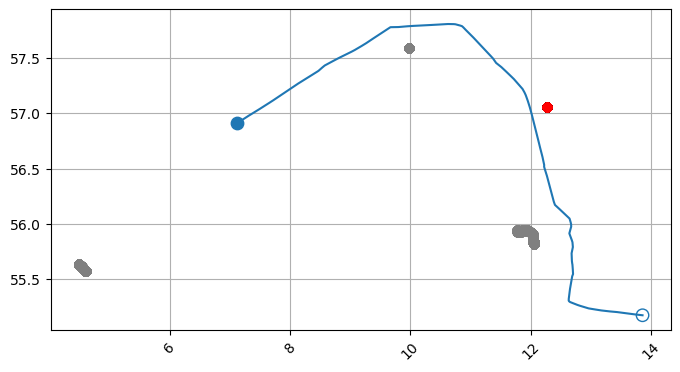

In [12]:
fig, ax = plt.subplots(figsize=(8,8))    # define fig and axes
trajectories[trajectories.index.isin([257136000])].iloc[0]['trajectory'].plot(axes=ax)
allais.plot(ax=ax, color='gray')
dwithin.plot(ax=ax, color='red')

# Storing in MobilityDB ([MEOS Example](https://libmeos.org/tutorialprograms/meos_store_ais/))

Now we will store the temporal objects we have created in MobilityDB.
To connect to MobilityDB (PostgreSQL), `psycopg2` is used. You can install it yourself or install `pymeos` with the `dbp2` option:
```shell
pip install pymeos[dbp2]
```
If you don't have MobilityDB set up, you can use the Docker image to quickly start:
```shell
docker run -d -p 5432:5432 --name pymeos-demo-db mobilitydb/mobilitydb:14-3.2-develop
```
MobilityDB also supports `asyncpg` and `psycopg` (psycopg3)

First, set up the connection parameters. Change any of the following values according to your configuration

In [13]:
from pymeos.db.psycopg2 import MobilityDB

host = 'localhost'
port = 5432
db = 'mobilitydb'
user = 'docker'
password = 'docker'

connection = MobilityDB.connect(host=host, port=port, database=db, user=user, password=password)
cursor = connection.cursor()

ModuleNotFoundError: No module named 'psycopg2'

Now, we will create the table where we will write our objects.

In [ ]:
cursor.execute("DROP TABLE IF EXISTS public.PyMEOS_demo;")
cursor.execute("CREATE TABLE public.PyMEOS_demo"
               "(MMSI integer, trajectory public.tgeogpoint, SOG public.tfloat);")
connection.commit()

Let's insert now the rows of the DataFrame into the MobilityDB table

In [ ]:
for mmsi, row in trajectories.iterrows():
    cursor.execute(f"INSERT INTO public.PyMEOS_demo(MMSI, trajectory, SOG) "
                   f"VALUES ({mmsi}, '{row.trajectory}', '{row.sog}');")
connection.commit()

Now, we will read one of the records that we just wrote

In [ ]:
cursor.execute("SELECT * FROM public.PyMEOS_demo WHERE MMSI = 257136000;")
mmsi, trajectory, sog = cursor.fetchone()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
trajectory.plot(axes=axes[0])
sog.plot(axes=axes[1])
plt.suptitle(f'Ship {mmsi}')
plt.show()

Finally, let's close the connection and wrap everything up

In [ ]:
connection.commit()
cursor.close()
pymeos_finalize()